In [23]:
!pip install altair

  Using cached altair-5.4.1-py3-none-any.whl.metadata (9.4 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
Using cached altair-5.4.1-py3-none-any.whl (658 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 5.1 MB/s eta 0:00:00:00:01
Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [24]:
import pandas as pd
import numpy as np
import zipfile 
import io
import os
import concurrent.futures
import time
import subprocess
import multiprocessing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import altair as alt

In [3]:
# Extract the zip and save in interim
data_folder = '../data'
zip_flight_data= data_folder + '/raw/itineraries_csv.zip'

extract_directory = data_folder +'/interim'

# Read the zip file
with zipfile.ZipFile(zip_flight_data, 'r') as z:
    z.extractall(extract_directory)

print(f"Extracted {zip_flight_data} to {extract_directory}")



Extracted ../data/raw/itineraries_csv.zip to ../data/interim


In [4]:
df_dict = {}

def process_folder(folder):
    def read_csv_generator(folder):
        files = os.listdir(f"../data/interim/itineraries_csv/{folder}")
        for file in files:
            file_path = f"../data/interim/itineraries_csv/{folder}/{file}"
            if file.endswith('.zip'):
                yield pd.read_csv(file_path, compression='zip')

    df_list = list(read_csv_generator(folder))
    if df_list:
        df_folder = pd.concat(df_list)
        df_folder.to_csv(f"../data/interim/itineraries_csv/{folder}.csv", index=False)
        print(f"Saved {folder}.csv")
        df_dict[folder] = df_folder  # Storing DataFrame in df_dict

# List of folders (e.g., airport codes)
folders = os.listdir("../data/interim/itineraries_csv")

# Limit the number of threads
max_threads = 4

# Measure execution time
start_time = time.time()

# Use ThreadPoolExecutor with a limited number of threads
with concurrent.futures.ThreadPoolExecutor(max_workers=max_threads) as executor:
    executor.map(process_folder, folders)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time:.2f} seconds")

# Check if df_dict is populated with folder names as keys
print(df_dict.keys())

# Now you should be able to access individual DataFrames, like 'OAK'
if 'OAK' in df_dict:
    print(df_dict['OAK'].shape)
else:
    print("OAK not found in df_dict")


Saved OAK.csv
Saved DEN.csv
Saved LGA.csv
Saved LAX.csv
Saved ATL.csv
Saved CLT.csv
Saved PHL.csv
Saved DTW.csv
Saved IAD.csv
Saved JFK.csv
Saved DFW.csv
Saved BOS.csv
Saved EWR.csv
Saved SFO.csv
Saved ORD.csv
Saved MIA.csv
Execution time: 535.87 seconds
dict_keys(['OAK', 'DEN', 'LGA', 'LAX', 'ATL', 'CLT', 'PHL', 'DTW', 'IAD', 'JFK', 'DFW', 'BOS', 'EWR', 'SFO', 'ORD', 'MIA'])
(527105, 23)


In [5]:
df_dict['DEN'].shape

(770429, 23)

In [6]:
df_combined = pd.concat([df_dict[code] for code in df_dict.keys() if code in df_dict])

df_combined.shape

(13519999, 23)

In [31]:
df_dict['DEN'].head(50)

,legId,searchDate,flightDate,startingAirport,destinationAirport,travelDuration,isBasicEconomy,isRefundable,isNonStop,totalFare,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,c4c15e7477db14816d98a386e73565f3,2022-05-18,2022-06-06,DEN,DTW,PT5H54M,False,False,False,544.60,...,1654527000||1654540920,2022-06-06T09:50:00.000-05:00||2022-06-06T14:4...,DFW||DTW,DEN||DFW,American Airlines||American Airlines,AA||AA,Airbus A321||Boeing 737-800,7320||9720,650||995,coach||coach
1,70ab7b83ef88886725bbe8e303178a3b,2022-05-18,2022-06-06,DEN,DTW,PT6H24M,False,False,False,548.60,...,1654540980||1654557060,2022-06-06T13:43:00.000-05:00||2022-06-06T19:1...,DFW||DTW,DEN||DFW,American Airlines||American Airlines,AA||AA,Airbus A321||Boeing 737-800,6960||9540,650||995,coach||coach
2,f97c09a0c43c5cd3614d3dade8a18e8b,2022-05-18,2022-06-06,DEN,DTW,PT4H42M,False,False,False,651.60,...,1654553220||1654560900,2022-06-06T17:07:00.000-05:00||2022-06-06T20:1...,ORD||DTW,DEN||ORD,United||United,UA||UA,Boeing 737-900||Embraer 175 (Enhanced Winglets),9240||5100,903||240,coach||coach
3,330f7175c4ed2c518e46fca1155af3f7,2022-05-18,2022-06-06,DEN,EWR,PT3H41M,False,False,True,237.60,...,1654577100,2022-06-07T00:45:00.000-04:00,EWR,DEN,United,UA,Boeing 737-900,13260,1621,coach
4,b92770186538da8daaf0e3fae6471ecf,2022-05-18,2022-06-06,DEN,EWR,PT6H51M,False,False,False,307.60,...,1654593480||1654606200,2022-06-07T05:18:00.000-04:00||2022-06-07T08:5...,IAD||EWR,DEN||IAD,United||United,UA||UA,Boeing 737-900||Airbus A320,11940||4620,1473||221,coach||coach
5,2076fc11556a9e3f287d2384ea9e9aca,2022-05-18,2022-06-06,DEN,EWR,PT8H6M,False,False,False,307.60,...,1654593480||1654610700,2022-06-07T05:18:00.000-04:00||2022-06-07T10:0...,IAD||EWR,DEN||IAD,United||United,UA||UA,Boeing 737-900||Boeing 757-200,11940||4800,1473||221,coach||coach
6,334e18cba75f74312b823b168a0caf1b,2022-05-18,2022-06-06,DEN,EWR,PT6H42M,False,False,False,316.10,...,1654565400||1654577340,2022-06-06T21:30:00.000-04:00||2022-06-07T00:4...,CLT||EWR,DEN||CLT,American Airlines||American Airlines,AA||AA,Airbus A321||Boeing 737-800,12180||6900,1346||545,coach||coach
7,832e326435954751014912e3b583130a,2022-05-18,2022-06-06,DEN,EWR,PT9H45M,False,False,False,317.58,...,1654530780||1654551900,2022-06-06T11:53:00.000-04:00||2022-06-06T17:4...,FLL||EWR,DEN||FLL,Spirit Airlines||Spirit Airlines,NK||NK,||AIRBUS INDUSTRIE A321 SHARKLETS,13980||11280,None||None,coach||coach
8,a02d8855961564b46c42f9f148244ea2,2022-05-18,2022-06-06,DEN,EWR,PT5H49M,False,False,False,328.60,...,1654508700||1654519440,2022-06-06T05:45:00.000-04:00||2022-06-06T08:4...,DTW||EWR,DEN||DTW,Delta||Delta,DL||DL,Boeing 737-900||Airbus A220-100,10200||5940,1142||485,coach||coach
9,76e60615dd2442ebaab6c2d7feb11585,2022-05-18,2022-06-06,DEN,EWR,PT3H42M,False,False,True,338.61,...,1654530120,2022-06-06T11:42:00.000-04:00,EWR,DEN,United,UA,Boeing 737-900,13320,1621,coach


In [7]:
print(df_combined.columns)

Index(['legId', 'searchDate', 'flightDate', 'startingAirport',
       'destinationAirport', 'travelDuration', 'isBasicEconomy',
       'isRefundable', 'isNonStop', 'totalFare', 'totalTravelDistance',
       'segmentsDepartureTimeEpochSeconds', 'segmentsDepartureTimeRaw',
       'segmentsArrivalTimeEpochSeconds', 'segmentsArrivalTimeRaw',
       'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode',
       'segmentsAirlineName', 'segmentsAirlineCode',
       'segmentsEquipmentDescription', 'segmentsDurationInSeconds',
       'segmentsDistance', 'segmentsCabinCode'],
      dtype='object')


In [8]:
df_combined.value_counts('isNonStop')

isNonStop
False    9564064
True     3955935
Name: count, dtype: int64

In [9]:
df_combined.value_counts('isBasicEconomy')

isBasicEconomy
False    12768661
True       751338
Name: count, dtype: int64

In [37]:
df_combined.shape

(13519999, 23)

In [43]:
df_combined.describe().style.format({
    "totalFare": "{:,.2f}",
    "totalTravelDistance": "{:,.2f}"
})

,totalFare,totalTravelDistance
count,"13,519,999.00","12,560,380.00"
mean,373.75,"1,569.62"
std,207.55,841.49
min,23.97,97.00
25%,223.58,862.00
50%,344.60,"1,392.00"
75%,487.60,"2,376.00"
max,"8,260.61","4,430.00"


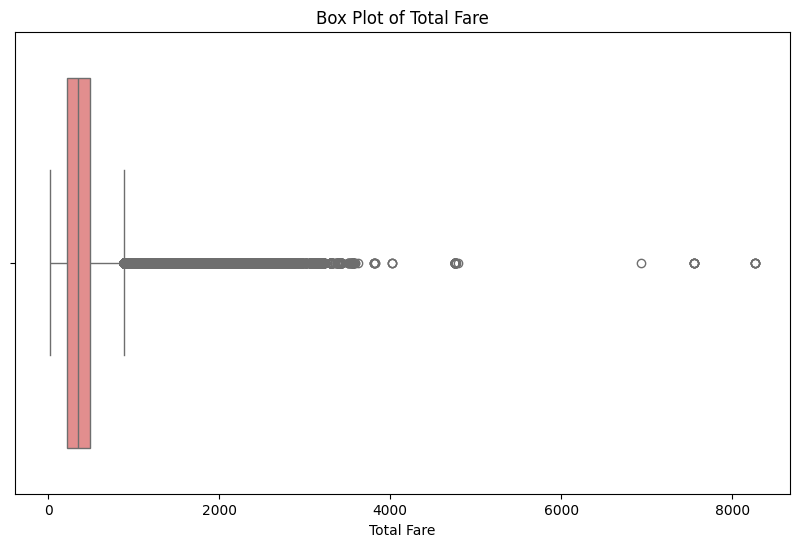

In [45]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_combined['totalFare'], color='lightcoral')
plt.title('Box Plot of Total Fare')
plt.xlabel('Total Fare')
plt.show()


In [100]:
df_combined.isnull().sum()

legId                                     0
searchDate                                0
flightDate                                0
startingAirport                           0
destinationAirport                        0
travelDuration                            0
isBasicEconomy                            0
isRefundable                              0
isNonStop                                 0
totalFare                                 0
totalTravelDistance                  959619
segmentsDepartureTimeEpochSeconds         0
segmentsDepartureTimeRaw                  0
segmentsArrivalTimeEpochSeconds           0
segmentsArrivalTimeRaw                    0
segmentsArrivalAirportCode                0
segmentsDepartureAirportCode              0
segmentsAirlineName                       0
segmentsAirlineCode                       0
segmentsEquipmentDescription         262676
segmentsDurationInSeconds                 0
segmentsDistance                     126985
segmentsCabinCode               

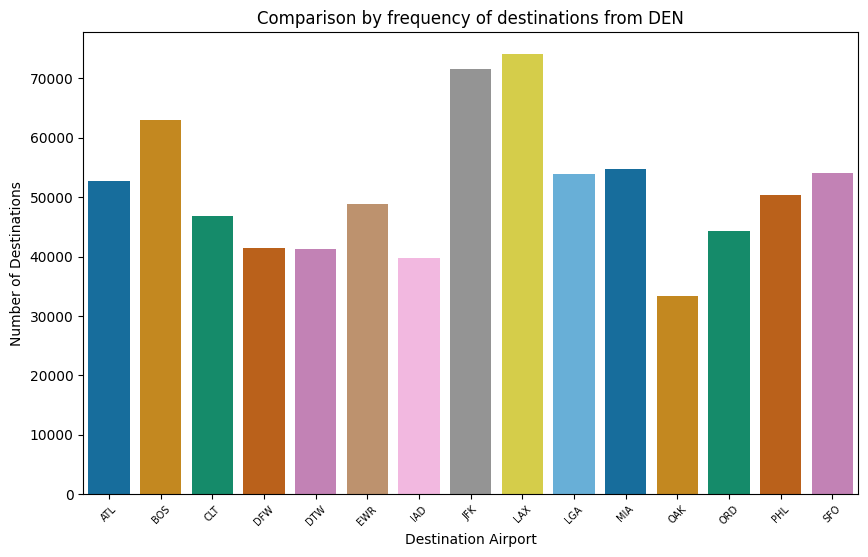

In [38]:
# Group by 'startingAirport' and count occurrences of 'destinationAirport'
destination_from_den = df_dict['DEN'].groupby('destinationAirport').size().reset_index(name='count')

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x='destinationAirport', y='count', data=destination_from_den, palette='colorblind')

plt.title('Comparison by frequency of destinations from DEN')
plt.xlabel('Destination Airport', fontsize=10)
plt.ylabel('Number of Destinations', fontsize=10)
plt.xticks(rotation=45, fontsize=7)

plt.show()


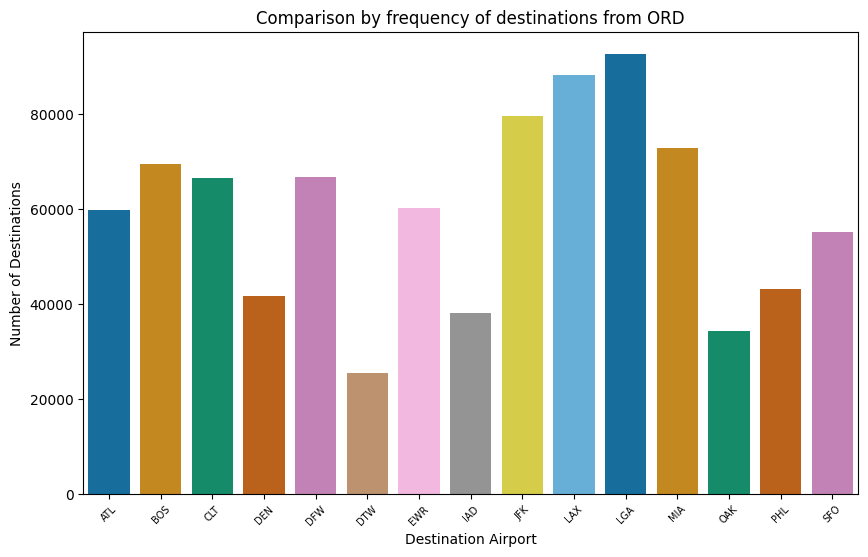

In [42]:
# Group by 'startingAirport' and count occurrences of 'destinationAirport'
destination_from_den = df_dict['ORD'].groupby('destinationAirport').size().reset_index(name='count')

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x='destinationAirport', y='count', data=destination_from_den, palette='colorblind')

plt.title('Comparison by frequency of destinations from ORD')
plt.xlabel('Destination Airport', fontsize=10)
plt.ylabel('Number of Destinations', fontsize=10)
plt.xticks(rotation=45, fontsize=7)

plt.show()


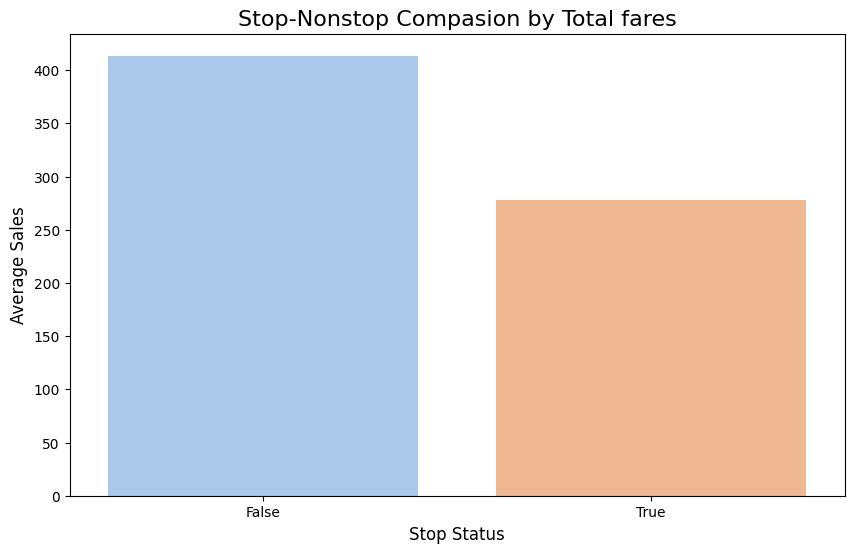

In [13]:
stop_non_stop = df_combined.groupby('isNonStop')['totalFare'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='isNonStop', y='totalFare', data=stop_non_stop, palette='pastel')

plt.title('Stop-Nonstop Compasion by Total fares', fontsize=16)
plt.xlabel('Stop Status', fontsize=12)
plt.ylabel('Average Sales', fontsize=12)

plt.show()

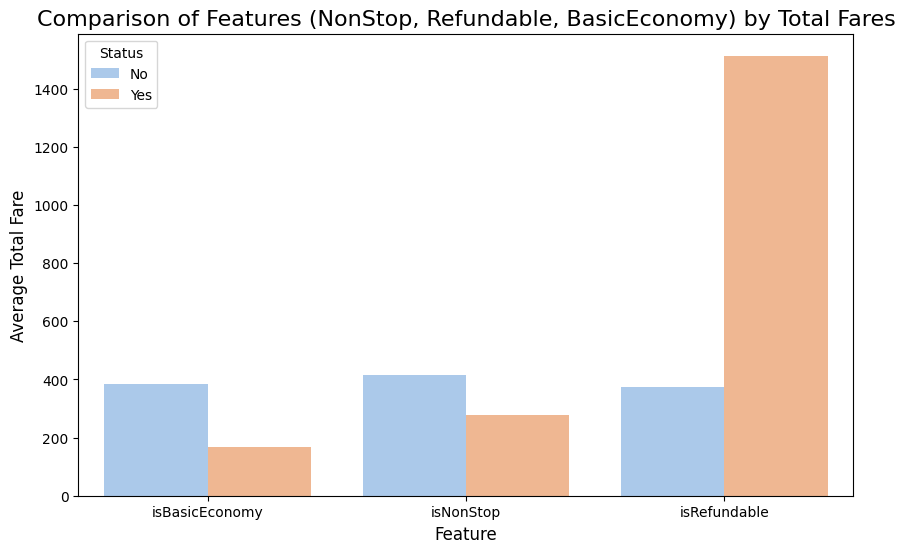

In [14]:
# Select the relevant columns (boolean features and 'totalFare')
bool_columns = ['isNonStop', 'isRefundable', 'isBasicEconomy']

# Melt the DataFrame to long format
df_melted = df_combined.melt(id_vars='totalFare', value_vars=bool_columns, 
                             var_name='Feature', value_name='Status')

# Group by 'Feature' and 'Status' to get the average 'totalFare'
feature_fare_comparison = df_melted.groupby(['Feature', 'Status'])['totalFare'].mean().reset_index()

# Map True/False to more descriptive labels
feature_fare_comparison['Status'] = feature_fare_comparison['Status'].map({True: 'Yes', False: 'No'})

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='totalFare', hue='Status', data=feature_fare_comparison, palette='pastel')

# Title and labels
plt.title('Comparison of Features (NonStop, Refundable, BasicEconomy) by Total Fares', fontsize=16)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Average Total Fare', fontsize=12)

plt.show()


In [11]:
df_eda = df_combined.copy()

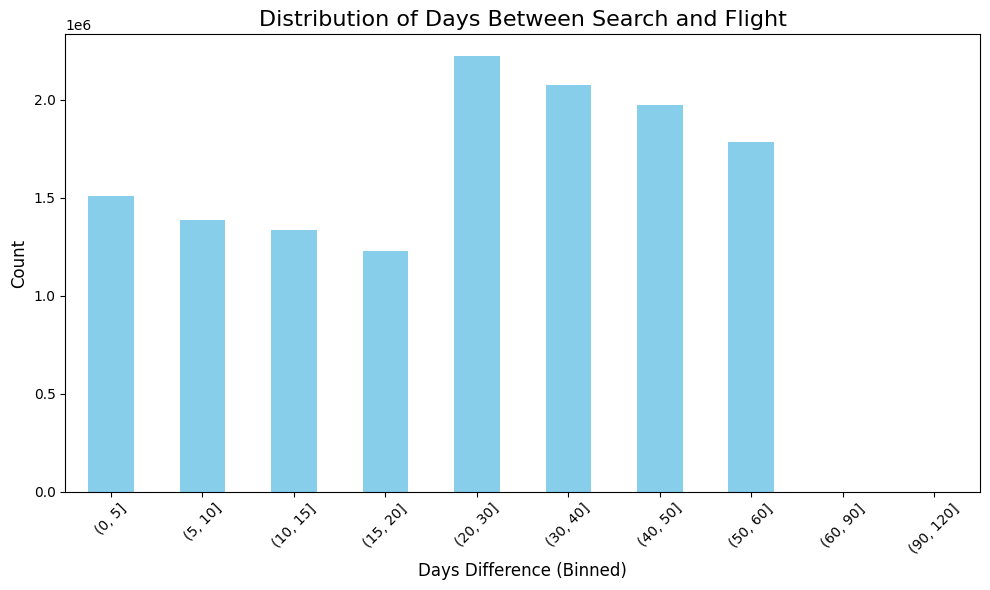

In [12]:
# Plot : Distribution of days between search and flight

df_eda['searchDate'] = pd.to_datetime(df_eda['searchDate'])
df_eda['flightDate'] = pd.to_datetime(df_eda['flightDate'])

# Calculate the difference in days
df_eda['date_diff'] = (df_eda['flightDate'] - df_eda['searchDate']).dt.days

bins = [0, 5, 10, 15, 20, 30, 40, 50, 60, 90, 120]
df_eda['binned_diff'] = pd.cut(df_eda['date_diff'], bins)

plt.figure(figsize=(10, 6))
df_eda['binned_diff'].value_counts(sort=False).plot(kind='bar', color='skyblue')

plt.title('Distribution of Days Between Search and Flight', fontsize=16)
plt.xlabel('Days Difference (Binned)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()


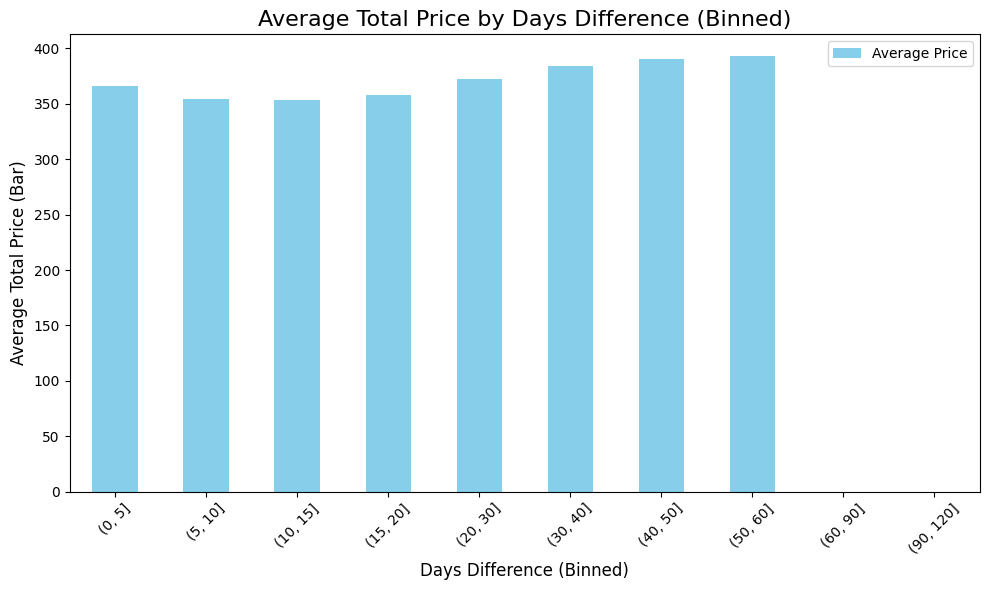

In [19]:
avg_price_per_bin = df_eda.groupby('binned_diff')['totalFare'].mean()

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for average prices by binned difference
avg_price_per_bin.plot(kind='bar', color='skyblue', ax=ax1, label='Average Price')

ax1.set_title('Average Total Price by Days Difference (Binned)', fontsize=16)
ax1.set_xlabel('Days Difference (Binned)', fontsize=12)
ax1.set_ylabel('Average Total Price (Bar)', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# Adding legend for both plots
fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

plt.tight_layout()
plt.show()

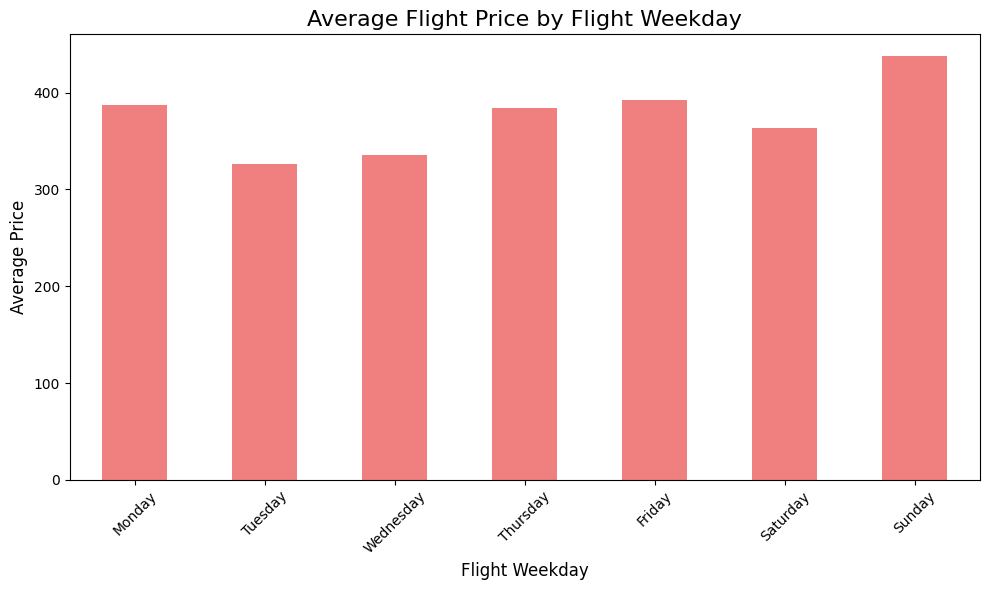

In [14]:
df_eda['flight_weekday'] = df_eda['flightDate'].dt.day_name()

avg_price_by_weekday = df_eda.groupby('flight_weekday')['totalFare'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

# Plot the average price by weekday
plt.figure(figsize=(10, 6))
avg_price_by_weekday.plot(kind='bar', color='lightcoral')

# Customize the plot
plt.title('Average Flight Price by Flight Weekday', fontsize=16)
plt.xlabel('Flight Weekday', fontsize=12)
plt.ylabel('Average Price', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

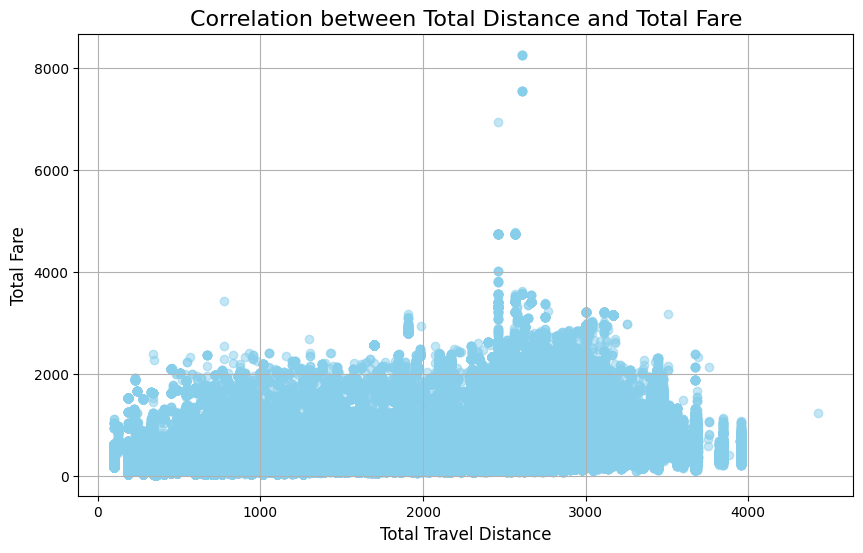

In [29]:
plt.figure(figsize=(10, 6))
plt.scatter(df_eda['totalTravelDistance'], df_eda['totalFare'], alpha=0.5, color='skyblue')
plt.title('Correlation between Total Distance and Total Fare', fontsize=16)
plt.xlabel('Total Travel Distance', fontsize=12)
plt.ylabel('Total Fare', fontsize=12)
plt.grid(True)
plt.show()

In [30]:
df_eda.head(20)

,legId,searchDate,flightDate,startingAirport,destinationAirport,travelDuration,isBasicEconomy,isRefundable,isNonStop,totalFare,...,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode,date_diff,binned_diff,flight_weekday
0,e1b137527b9175d7d930c3af82e70ae0,2022-04-19,2022-05-20,OAK,ATL,PT7H52M,False,False,False,103.98,...,OAK||DEN,Frontier Airlines||Frontier Airlines,F9||F9,||Airbus A320,9180||10620,943||1207,coach||coach,31,"(30, 40]",Friday
1,d813ebd107e3fa700206c0d96015da7a,2022-04-19,2022-05-20,OAK,ATL,PT6H15M,False,False,False,216.58,...,OAK||LAX,Spirit Airlines||Spirit Airlines,NK||NK,||AIRBUS INDUSTRIE A320 SHARKLETS,4920||15600,None||None,coach||coach,31,"(30, 40]",Friday
2,e8ece5ad6f5962c696e06e031fc2a24a,2022-04-19,2022-05-20,OAK,ATL,PT9H6M,False,False,False,216.58,...,OAK||LAX,Spirit Airlines||Spirit Airlines,NK||NK,AIRBUS INDUSTRIE A320 SHARKLETS||AIRBUS INDUST...,4920||15600,None||None,coach||coach,31,"(30, 40]",Friday
3,c004a54681335100f326c9613b3c9448,2022-04-19,2022-05-20,OAK,ATL,PT6H17M,False,False,False,237.58,...,OAK||LAS,Spirit Airlines||Spirit Airlines,NK||NK,AIRBUS INDUSTRIE A320 SHARKLETS||Airbus A319,5580||13980,None||None,coach||coach,31,"(30, 40]",Friday
4,4a42bbf77211b4afa7b9e14005949120,2022-04-19,2022-05-20,OAK,ATL,PT14H12M,False,False,False,307.21,...,OAK||SEA,Alaska Airlines||Alaska Airlines,AS||AS,Boeing 737-900||Boeing 737-900,7500||17580,672||2178,coach||coach,31,"(30, 40]",Friday
5,9157572cdd530976f707a162a4fcfde8,2022-04-19,2022-05-20,OAK,ATL,PT9H8M,True,False,False,318.60,...,OAK||SEA,Alaska Airlines||Alaska Airlines,AS||AS,Boeing 737-800||Boeing 737-900,7620||17820,672||2178,coach||coach,31,"(30, 40]",Friday
6,1818c5a6f7059cfde40105cdacda9c29,2022-04-19,2022-05-20,OAK,ATL,PT14H13M,False,False,False,366.58,...,OAK||LAS,Spirit Airlines||Spirit Airlines,NK||NK,AIRBUS INDUSTRIE A320 SHARKLETS||Airbus A319,5460||13980,None||None,coach||coach,31,"(30, 40]",Friday
7,e8baed3d41a0c35856f7591a5baad060,2022-04-19,2022-05-20,OAK,ATL,PT13H14M,False,False,False,410.69,...,OAK||LAX||MEM,Delta||Delta||Delta,DL||DL||DL,Embraer 175 (Enhanced Winglets)||Boeing 737-80...,4860||13320||4380,338||1615||332,coach||coach||coach,31,"(30, 40]",Friday
8,965e29ef7e8d11bf05f723a28ab8e4e0,2022-04-19,2022-05-20,OAK,ATL,PT12H40M,False,False,False,437.71,...,OAK||SLC||AUS,Delta||Delta||Delta,DL||DL||DL,Embraer 175 (Enhanced Winglets)||Airbus A220-1...,7020||9960||7980,588||1078||811,coach||coach||coach,31,"(30, 40]",Friday
9,50aae8333ddca38814b9756bba08daad,2022-04-19,2022-05-20,OAK,ATL,PT12H47M,False,False,False,449.70,...,OAK||SLC||DFW,Delta||Delta||Delta,DL||DL||DL,Embraer 175 (Enhanced Winglets)||Airbus A321||...,7020||9540||7500,588||992||725,coach||coach||coach,31,"(30, 40]",Friday


In [76]:
def analyze_stopover_frequency(df):
    # Calculate date difference in days
    df['date_diff'] = (pd.to_datetime(df['flightDate']) - pd.to_datetime(df['searchDate'])).dt.days

    # Calculate the number of segments based on `segmentsDurationInSeconds`
    df['num_segments'] = df['segmentsDurationInSeconds'].apply(lambda x: x.count('||') + 1)

    # Define bins for the date difference (customize as needed)
    bins = [0, 5, 10, 15, 20, 30, 40, 50, 60, 90, 120]
    df['date_diff_bins'] = pd.cut(df['date_diff'], bins)

    # Group by binned date difference and calculate the average number of segments
    result = df.groupby('date_diff_bins')['num_segments'].mean().reset_index()

    # Rename columns for clarity
    result.columns = ['Date Difference (Days)', 'Average Number of Segments']

    return result

# Run the analysis
result = analyze_stopover_frequency(df_eda)
print(result)


  Date Difference (Days)  Average Number of Segments
0                 (0, 5]                    1.815180
1                (5, 10]                    1.796901
2               (10, 15]                    1.797319
3               (15, 20]                    1.791176
4               (20, 30]                    1.780314
5               (30, 40]                    1.770588
6               (40, 50]                    1.767531
7               (50, 60]                    1.769464
8               (60, 90]                         NaN
9              (90, 120]                         NaN


In [36]:
# searchDate 컬럼을 datetime 형식으로 변환
df_eda['searchDate'] = pd.to_datetime(df_eda['searchDate'])

# 시작일과 종료일 확인
start_date = df_eda['searchDate'].min()
end_date = df_eda['searchDate'].max()

print("시작일:", start_date)
print("종료일:", end_date)


시작일: 2022-04-16 00:00:00
종료일: 2022-05-19 00:00:00


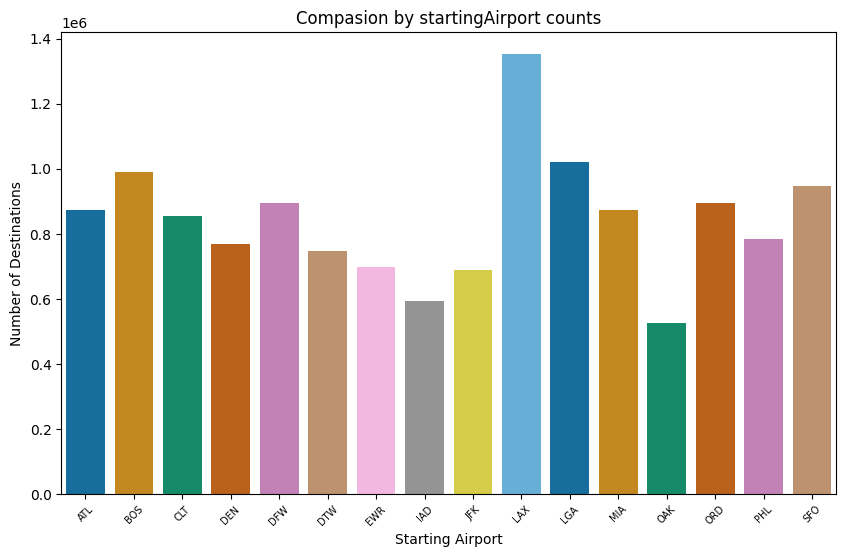

In [40]:
airport_counts = df_eda.groupby('startingAirport').size().reset_index(name='count')

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x='startingAirport', y='count', data=airport_counts, palette='colorblind')

plt.title('Compasion by startingAirport counts')
plt.xlabel('Starting Airport', fontsize=10)
plt.ylabel('Number of Destinations', fontsize=10)
plt.xticks(rotation=45, fontsize=7)

plt.show()


In [48]:
df_eda['num_segments'] = df_eda['segmentsDurationInSeconds'].apply(lambda x: x.count('||'))

df_eda['num_segments'].value_counts()

num_segments
1    8569171
0    3955935
2     957175
3      37718
Name: count, dtype: int64